## Carga de datos

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Dropout,Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras.models import load_model

# Paso 1: Cargar los datos
data_folder = "./Dataset"
image_folder = os.path.join(data_folder, "train_images_256")
mask_folder = os.path.join(data_folder, "train_masks_256")

# Obtener lista de nombres de archivo para las imágenes
image_files = os.listdir(image_folder)

2023-07-28 21:49:18.828172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 21:49:20.454646: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("TensorFlow version:", tf.__version__)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

TensorFlow version: 2.13.0


## Preprocesamiento de Datos

In [2]:

# Paso 2: Preparar los datos
# Redimensionar todas las imágenes a un tamaño específico
image_size = (256, 256)

# Crear listas para almacenar las imágenes y sus máscaras
images = []
masks = []

# cargar imagenes y mascaras
for filename in image_files:
    image_path = os.path.join(image_folder, filename)
    mask_path = os.path.join(mask_folder, filename)

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # image = cv2.resize(image, image_size)
    # mask = cv2.resize(mask, image_size)

    # Normalizar las imágenes y máscaras para que los valores estén entre 0 y 1
    image = image / 255.0
    mask = mask / 255.0

    # Cambiar los píxeles en la máscara mayores que 0 a 255
    # mask[mask > 0] = 255

    images.append(image)
    masks.append(mask)


# Convertir las listas de imágenes y máscaras a arreglos numpy
images = np.array(images)
masks = np.array(masks)

# Agregar una dimensión adicional para el canal (ya que las imágenes están en escala de grises)
images = np.expand_dims(images, axis=-1)
masks = np.expand_dims(masks, axis=-1)




In [13]:
# image_files = os.listdir(image_folder)
# half_length = len(image_files) // 4
# image_files = image_files[:half_length]

# print(len(image_files))

## Modelo U-net

In [3]:


def unet(input_layer=(256, 256, 1), start_neurons=16):
    inputs = Input(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

    model = Model(inputs=inputs, outputs=output_layer)
    
    return model



## Carga y Entrenamiento del modelo
#### - save: para entrenar por primera vez
#### -  load: para cargar un modelo pre-entrenado

In [65]:


save_load = "load"

#nombre del modelo pre-entrenado
# model_name = "model_30_epocas.h5"
model_name = "model_100E_32N.h5"

model  = None

if save_load == "save":
    model = unet(input_layer=(256,256,1), start_neurons=32)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(images, masks, batch_size=8, epochs=10, validation_split=0.2)
    model.save("./DataSave/" + model_name)
else:
    model = tf.keras.models.load_model("./DataSave/" + model_name)

## Test de Mascara 

In [57]:
pip install tensorflow_hub


  Using cached tensorflow_hub-0.14.0-py2.py3-none-any.whl (90 kB)
Note: you may need to restart the kernel to use updated packages.


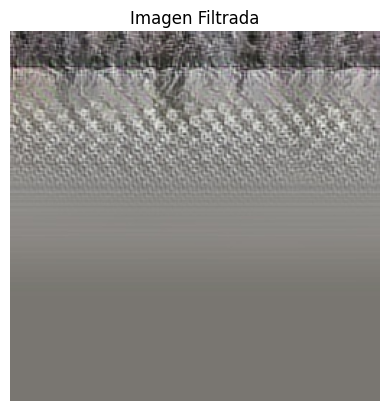

In [68]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import matplotlib.pyplot as plt

def apply_style_transfer(input_image_path, style_reference_image_path, output_image_path):
    # Cargar las imágenes de entrada y referencia de estilo
    input_image = cv2.imread(input_image_path)
    style_reference_image = cv2.imread(style_reference_image_path)

    # Preprocesar las imágenes para el modelo
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    style_reference_image = cv2.cvtColor(style_reference_image, cv2.COLOR_BGR2RGB)
    input_image = tf.image.resize(input_image, (256, 256)) / 255.0
    style_reference_image = tf.image.resize(style_reference_image, (256, 256)) / 255.0
    input_image = tf.expand_dims(input_image, axis=0)
    style_reference_image = tf.expand_dims(style_reference_image, axis=0)

    # Cargar el modelo de transferencia de estilo de TensorFlow Hub
    model = hub.load("https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2")

    # Aplicar la transferencia de estilo
    stylized_image = model(tf.constant(input_image), tf.constant(style_reference_image))[0]

    # Guardar la imagen filtrada
    stylized_image = tf.image.convert_image_dtype(stylized_image, tf.uint8)
    stylized_image = tf.image.encode_jpeg(stylized_image[0]).numpy()
    with open(output_image_path, "wb") as f:
        f.write(stylized_image)
    
     # Cargar la imagen filtrada y hacer el plot
    filtered_image = cv2.imread(output_image_path)
    filtered_image = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB)

    plt.imshow(filtered_image)
    plt.title('Imagen Filtrada')
    plt.axis('off')
    plt.show()



input_image_path = "ejemplo5.tif"  # Ruta de la imagen a filtrar
style_reference_image_path = "./Dataset/train_images_256/041871.000163.tif"  # Ruta de la imagen de referencia de estilo
output_image_path = "output_image.png"  # Ruta de la imagen filtrada de salida

apply_style_transfer(input_image_path, style_reference_image_path, output_image_path)


1/1 [==============================] - 0s 90ms/step


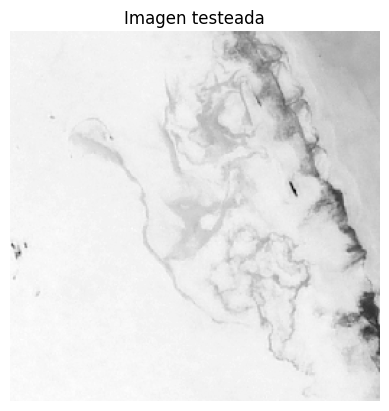

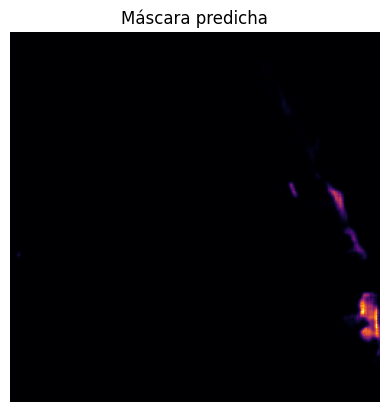

In [83]:

# ejemplo de predicción
# image_path = "./Dataset/train_images_256/041871.000163.tif"
# image_path = "./image_input_partition/L15-0585E-0954Ngray_part134.tif"

# image_path = "output_image.png"
image_path = "ejemplo.png"

test_image = cv2.imread( image_path, cv2.IMREAD_GRAYSCALE)

test_image = cv2.bitwise_not(test_image)

# # # Ajustar el contraste y el brillo para resaltar más las partes claras
# alpha = 0.5  # Contraste (1.0 es el valor neutral, valores < 1.0 disminuyen el contraste)
# beta = 10    # Brillo (valor añadido a cada píxel)
# test_image = cv2.convertScaleAbs(test_image, alpha=alpha, beta=beta)




test_image = cv2.resize(test_image, image_size)
test_image = test_image.astype('float32') / 255.0
test_image = np.expand_dims(test_image, axis=0)
test_image = np.expand_dims(test_image, axis=-1)

predicted_mask = model.predict(test_image)


# Mostrar la imagen testeada
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title('Imagen testeada')
plt.axis('off')
plt.show()


#Mostrar la máscara predicha
predicted_mask = predicted_mask.squeeze()
plt.imshow(predicted_mask, cmap='inferno')
plt.title('Máscara predicha')
plt.axis('off')
plt.show()


